## Least squares TDOA and TOA is not a convex problem

If we work with a time-difference-of-arrival system where a single transmission is simultaneously received by multiple receivers, we could try to express it as a least square minimization problem

$$ \begin{align}
min & \: \epsilon^T W \epsilon \\
s.t. & \: t_i = \tau + \| p - \pi_i\| + \epsilon_i
\end{align}$$

Here

- $i$ represents the reception on a $i^\text{th}$ receiver
- $t_i$ is the time of the reception
- $\tau$ is the time of transmission
- $p$ is the position of the transmitter
- $\pi_i$ is the position of the $i^\text{th}$ receiver.
- $\epsilon_i$ is the error caused by violating each constraint. Correspondingly, $\epsilon$ is a vector of $\epsilon_i$'s

This problem formulation is not convex. Thus it cannot be solved by standard quadratic optimization, cone programming or semidefinite methods.

One possibility is to use gradient desent with the appropriate starting points.

### Time of Arrival (TOA)

Here is a simplified TOA formulation:

If we assume that $\tau$ is known (and precise) this becomes a TOA problem.

Note that $t_i - \tau = \frac{\text{actual distance}}{c}$. If $\tau = 0$ then we can replace $t_i$ by the time of flight.

Thus the constrains become $\frac{\text{actual dist}_i}{c} = \frac{\text{estimated dist}_i}{c} + \epsilon_i$

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import itertools

# define class obejcts
def pos(x,y):
    """Quick shortcut to convert X,Y position to numpy array"""
    return np.array([x,y])

def pos3D(x,y,z):
    """Quick shortcut to convert X,Y,Z position to numpy array"""
    return np.array([x,y,z])

class Device:
    """This is a general class for a radio device"""
    def __init__(self, name, position):
        """Expects a string for name and a numpy array with position coordinates in meters"""
        self.name = name
        self.pos = position

    def __str__(self):
        """Display string"""
        return "device {} at pos = {}".format(self.name, self.pos)

    def distanceTo(self, otherDevice):
        """When supplied the identity of another device, outputs the distance in meters"""
        return np.linalg.norm(self.pos - otherDevice.pos, ord = 2)

    def distances(self, positions):
        """Given a multi dimensional array of positions with the coordinates in the last axis,
        this function finds the distance to each of those points"""
        nDim = len(positions.shape)
        return np.linalg.norm(positions - self.pos, ord = 2, axis = nDim-1)

    def plot(self, *args, **kwargs):
        plt.plot(self.pos[0], self.pos[1], *args, label = self.name, **kwargs)

Transmitter:  device TX at pos = [   0. 5000.]
Receivers used: 3


<IPython.core.display.Javascript object>


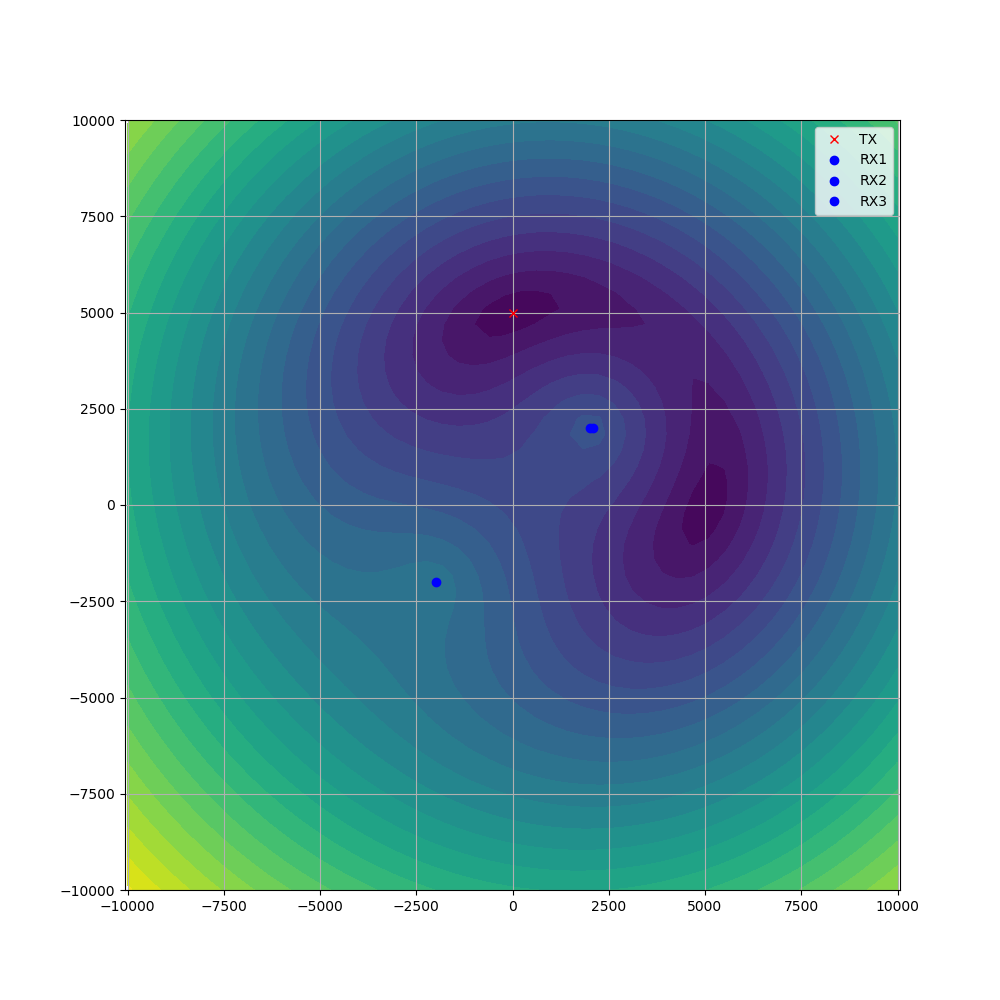

In [34]:
def ToaErrorFunction(TX, RX,
                     numPoints = 100,
                     contours = 25,
                     size = ((-2000,2000),(-2000,2000)),
                     noiseStdev = 0, # standard deviation of noise
                     **kwargs):
    
    # interpret inputs and settings
    txName, txPos = next(iter(TX.items())) # get exactly one item from the dict (there should only be 1)
    tx = Device(txName, pos(*txPos))
    print("Transmitter: ", tx)
    rxDevices = []
    for rxName, rxPos in RX.items():
        rxDevices.append(Device(rxName,pos(*rxPos)))
    print("Receivers used: {}".format(len(rxDevices)))
    ((xMin, xMax), (yMin, yMax)) = size
    
    # generate grid
    x1 = np.linspace(xMin, xMax, numPoints)
    x2 = np.linspace(yMin, yMax, numPoints)
    x1,x2 = np.meshgrid(x1, x2)
    meshgridDim = len(x1.shape)
    # The position matrix contains coordinates of multiple points in a multi dimensional grid.
    # The coordinates are in the last axis
    positions = np.stack((x1, x2), axis = meshgridDim)

    # calculate error at all points on the grid
    def getTotalError(txDevice, rxDevices, positions):
        """Add description"""
        nRxDevices = len(rxDevices)
        error = np.empty([nRxDevices, *positions.shape[0:-1]])

        def getError(txDevice, rxDevice, positions):
            """Add description"""
            measuredDistance = rxDevice.distanceTo(txDevice) + np.random.normal(scale = noiseStdev)
            estimatedDistance = rxDevice.distances(positions)
            error = measuredDistance - estimatedDistance
            return error
        
        for devIndex, dev in enumerate(rxDevices):
            error[devIndex] = getError(txDevice, dev, positions)
        return np.linalg.norm(error, ord = 2, axis = 0)

    errorGrid = getTotalError(tx, rxDevices, positions)
    
    # plot and show
    plt.figure(figsize=(10,10))
    plt.axis('equal')
    plt.xlim([xMin, xMax])
    plt.ylim([yMin, yMax])
    tx.plot('rx')
    for dev in rxDevices:
        dev.plot('bo')
    plt.contourf(x1, x2, errorGrid, contours)
    plt.legend()
    plt.grid()
    plt.show()
    
# setup simulation parameters
# all positions are in m
settings = {
            'TX': {
                    'TX': (0.,5000.)
                },
            'RX': {
                    'RX1': (-2000., -2000),
                    'RX2': (2000, 2000),
                    'RX3': (2100, 2000),
#                     'RX3': (-2000, 2000),
#                     'RX4': (2000, -2000),
#                     'RX5': (0, 3000),
#                     'RX6': pos(0, -3000)
                 },
            'numPoints': 50,
            'contours': 25,
            'size': ((-10000, 10000), (-10000, 10000))
           }

# run simulation with provided parameters
ToaErrorFunction(**settings)

### Time Difference of Arrival

This analysis is based on the reverse GPS paper.

We would like to generate this same error graph for a TDOA problem. In real TDOA $\tau$ cannot be directly eliminated. However, the minimization problem can be split up into two parts and which can be seperately minimized.

$$ \begin{align}
min & \: \epsilon^T W \epsilon \\
s.t. & \: t_i = \tau + \| p - \pi_i\| + \epsilon_i
\end{align} $$

Which is equivalent to

$$ \begin{align}
\min_{\tau, p} & \: \left[ \left( t_i - \tau - \| p - \pi_i\| \right) \right]^T W \left[ \left( t_i - \tau - \| p - \pi_i\| \right) \right] \\
\equiv \min_{p} & \: \| \left( I - Q Q^T\right) W \left( t_i - \| p - \pi_i\| \right)\|^2
\end{align} $$

Transmitter:  device TX at pos = [1000. 1000.]
Receivers used: 3


<IPython.core.display.Javascript object>


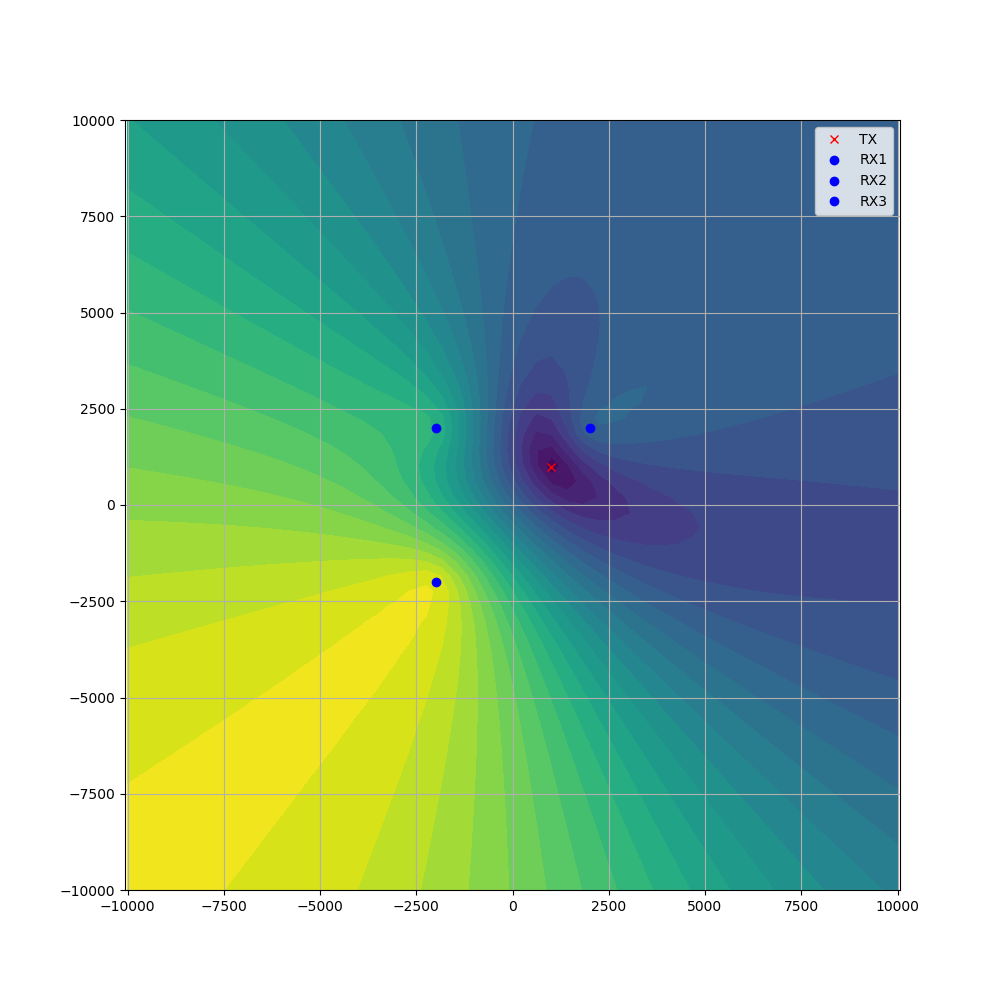

In [42]:
def TdoaErrorFunction(TX, RX,
                     numPoints = 100,
                     contours = 25,
                     size = ((-2000,2000),(-2000,2000)),
                     noiseStdev = 0, # standard deviation of noise
                     **kwargs):
    
    # interpret inputs and settings
    txName, txPos = next(iter(TX.items())) # get exactly one item from the dict (there should only be 1)
    tx = Device(txName, pos(*txPos))
    print("Transmitter: ", tx)
    rxDevices = []
    for rxName, rxPos in RX.items():
        rxDevices.append(Device(rxName,pos(*rxPos)))
    print("Receivers used: {}".format(len(rxDevices)))
    ((xMin, xMax), (yMin, yMax)) = size
    
    # generate grid
    x1 = np.linspace(xMin, xMax, numPoints)
    x2 = np.linspace(yMin, yMax, numPoints)
    x1,x2 = np.meshgrid(x1, x2)
    meshgridDim = len(x1.shape)
    # The position matrix contains coordinates of multiple points in a multi dimensional grid.
    # The coordinates are in the last axis
    positions = np.stack((x1, x2), axis = meshgridDim)

    # calculate error at all points on the grid
    def getTotalError(txDevice, rxDevices, positions):
        # TODO: this function must be updated for TDOA
        """Add description"""
        nRxDevices = len(rxDevices)
        error = np.empty([nRxDevices, *positions.shape[0:-1]])
        L = -np.ones((nRxDevices, 1))
        Q, R = np.linalg.qr(L, mode = 'reduced')
        A = (np.eye(nRxDevices) - Q*Q.T)

        def getError(txDevice, rxDevice, positions):
            # TODO: this function must be updated for TDOA
            """Add description"""
            measuredDistance = rxDevice.distanceTo(txDevice) + np.random.normal(scale = noiseStdev)
            estimatedDistance = rxDevice.distances(positions)
            error = measuredDistance - estimatedDistance
            return error
        
        for devIndex, dev in enumerate(rxDevices):
            error[devIndex] = getError(txDevice, dev, positions)
            
        # TODO: replace this with a better vectorized solution
        errShape1, errShape2, errShape3 = error.shape
        for i2, i3 in itertools.product(range(errShape2), range(errShape3)):
            error[:,i2, i3] = np.dot(A, error[:,i2,i3])

        return np.linalg.norm(error, ord = 2, axis = 0)

    errorGrid = getTotalError(tx, rxDevices, positions)
    
    # plot and show
    plt.figure(figsize=(10,10))
    plt.axis('equal')
    plt.xlim([xMin, xMax])
    plt.ylim([yMin, yMax])
    tx.plot('rx')
    for dev in rxDevices:
        dev.plot('bo')
    plt.contourf(x1, x2, errorGrid, contours)
    plt.legend()
    plt.grid()
    plt.show()
    
# setup simulation parameters
# all positions are in m
settings = {
            'TX': {
                    'TX': (1000.,1000.)
                },
            'RX': {
                    'RX1': (-2000., -2000),
                    'RX2': (2000, 2000),
                    'RX3': (-2000, 2000),
#                     'RX4': (2000, -2000),
#                     'RX5': (0, 3000),
#                     'RX6': pos(0, -3000)
                 },
            'numPoints': 50,
            'contours': 25,
            'size': ((-10000, 10000), (-10000, 10000)),
            'noiseStdev': 100
           }

# run simulation with provided parameters
TdoaErrorFunction(**settings)